# MD-DTW Analysis Framework  for b9d2 analysis

## Setup: Configure Environment and Import Functions

In [5]:
import os

os.chdir(os.environ['MORPHSEQ_REPO_ROOT']) 

import pandas as pd

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,


    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,

    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,

    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    plot_trajectories_faceted,
    PASTEL_COLORS,

    # K-SELECTION PIPELINE (Phase 1) - SEPARATE FUNCTIONS for granular control
    evaluate_k_range,              # Evaluate multiple k values with metrics
    plot_k_selection,              # Visualize k comparison across all metrics
    classify_membership_2d,        # Core/uncertain/outlier classification

    # Consensus clustering (Phase 2)
    run_consensus_pipeline,        # Full two-stage pipeline
)

# Import add_membership_column from k_selection module directly
from src.analyze.trajectory_analysis.k_selection import add_membership_column

from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

from pathlib import Path
results_dir = "results/mcolon/20251219_b9d2_phenotype_extraction"
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

print("✓ Imports successful!")

✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [6]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
# df = pd.read_csv('path/to/your/data.csv')

#Option 2: Use existing data loading utilities

from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# List all experiments you want to analyze together
experiment_ids = ['20251119','20251121', '20251125']  # Add your experiment IDs

# Load and combine
dfs = []
for exp_id in experiment_ids:
    df_exp = load_experiment_dataframe(exp_id, format_version='df03')
    df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
    dfs.append(df_exp)
    print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# Concatenate all experiments
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Experiments: {df['experiment_id'].unique()}")

  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251119.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251119.csv


    Curvature: 10440 rows
    Metadata: 8086 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 8086 rows
    Unique snip_ids: curvature=10440, metadata=8086, merged=8086
    ⚠️  2354 snip_ids only in curvature (dropped)
✓ Loaded 20251119: 8086 rows, 30 embryos
  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251121.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251121.csv
    Curvature: 16608 rows
    Metadata: 9127 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 9127 rows
    Unique snip_ids: curvature=16608, metadata=9127, merged=9127
    ⚠️  

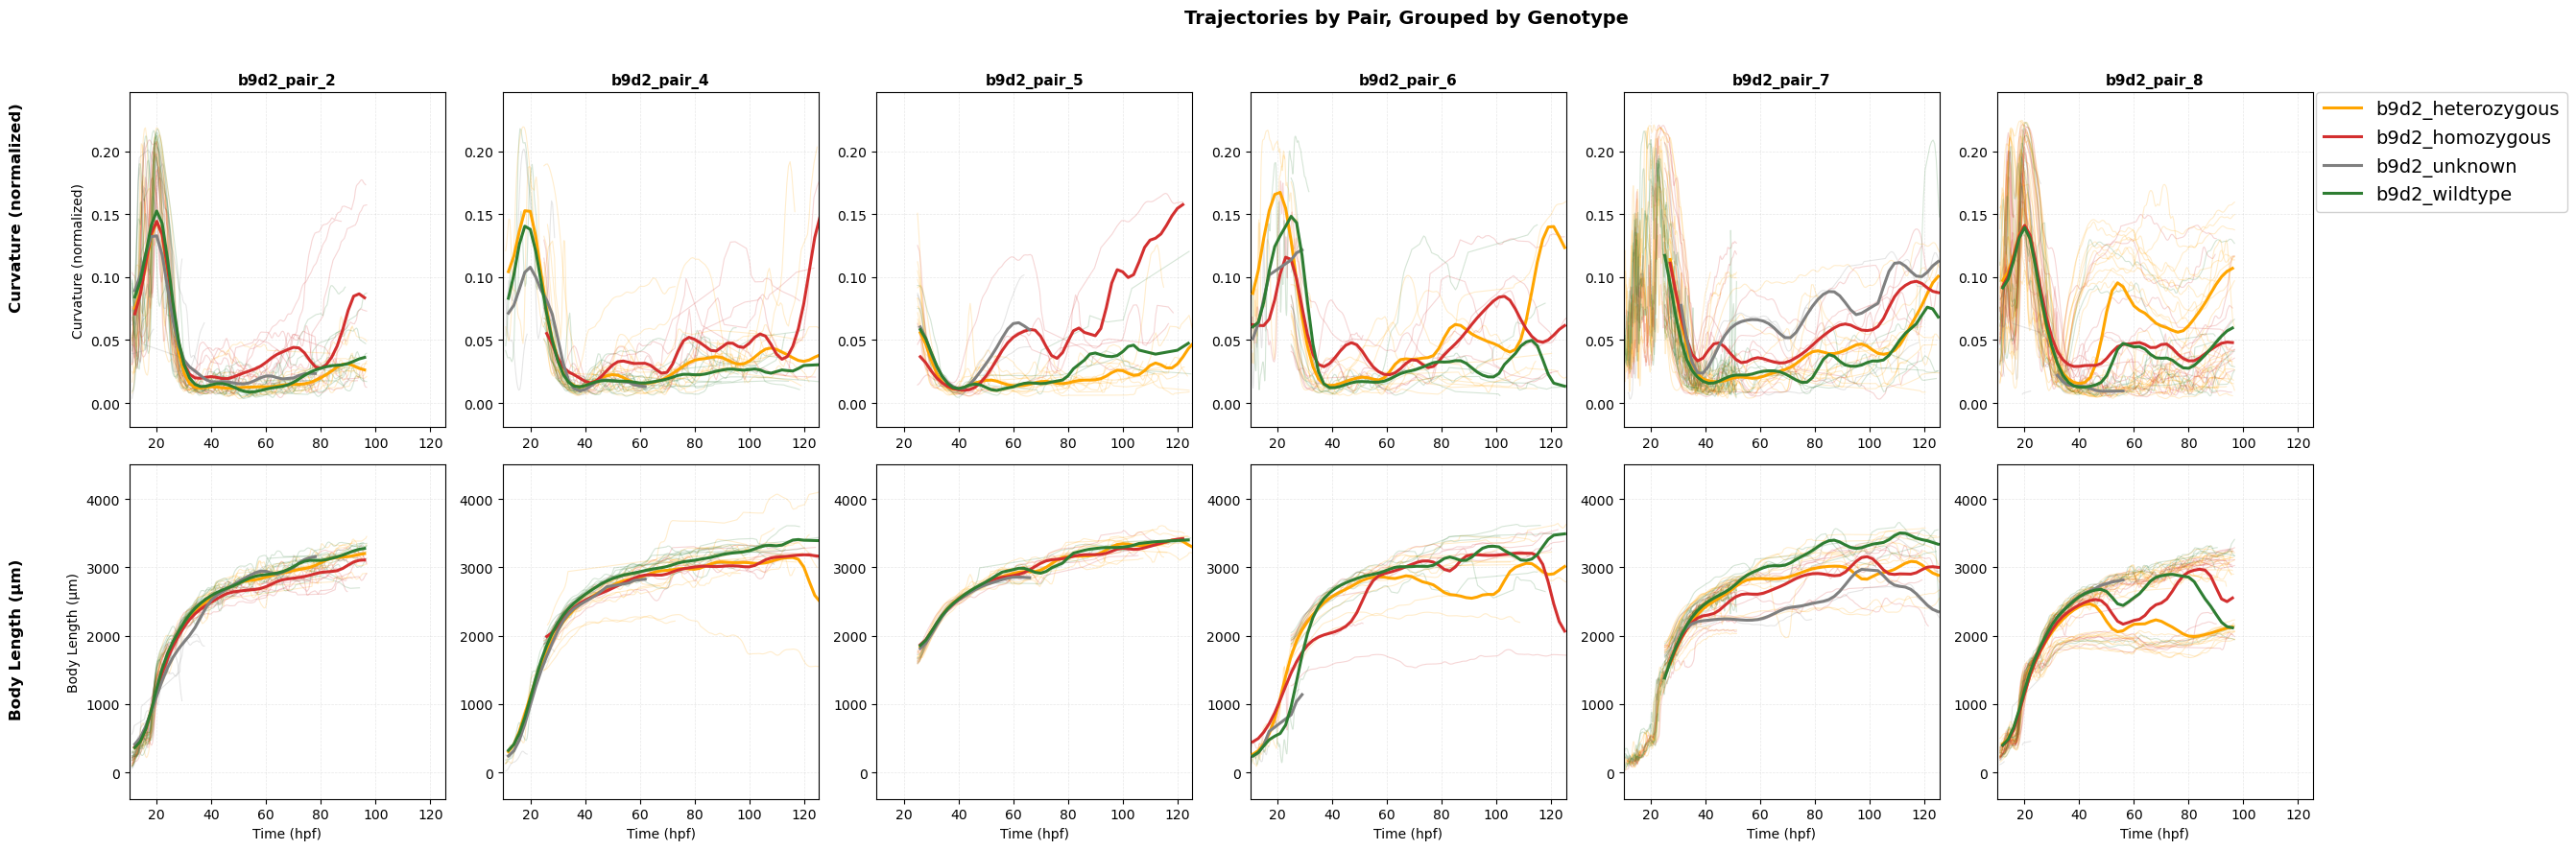

In [7]:
 
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

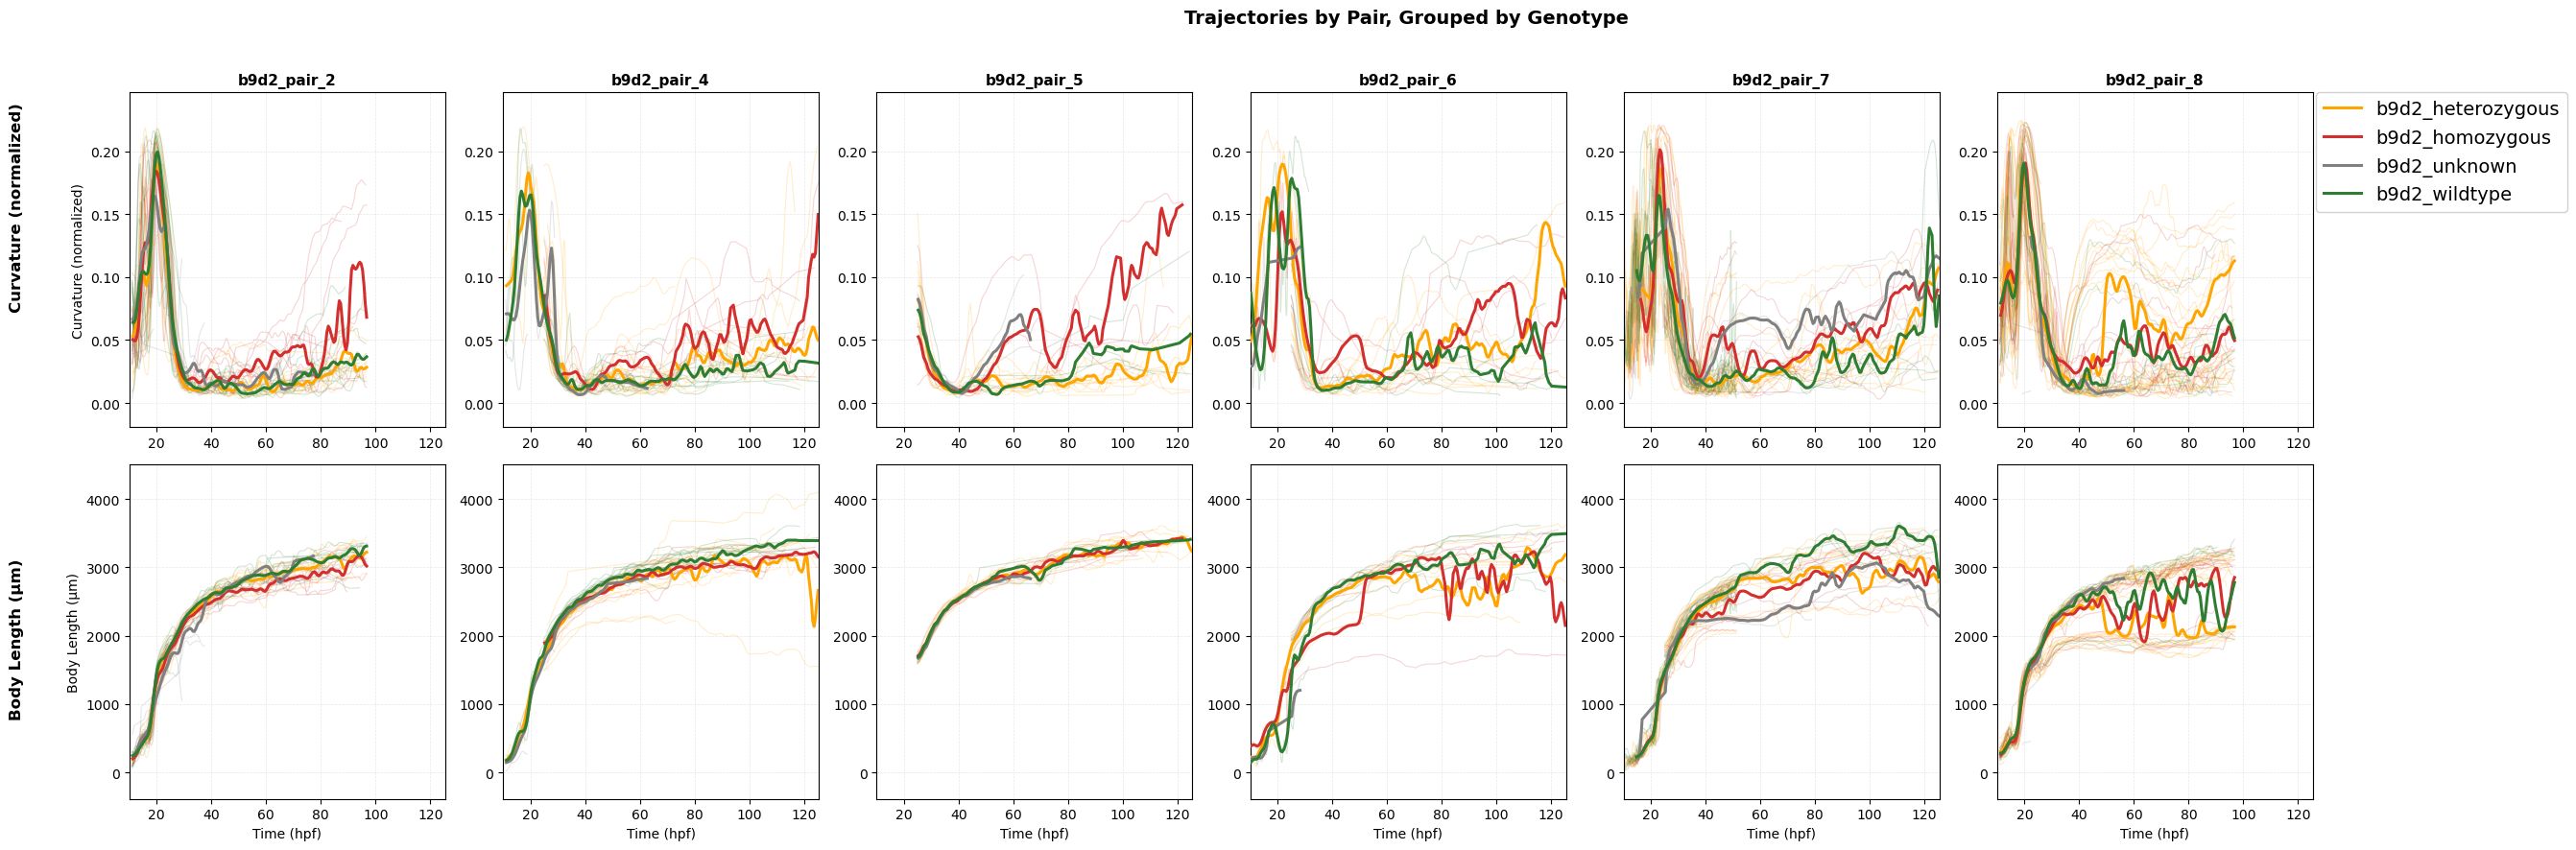

In [8]:

# Optional: Color by genotype instead to validate clusters separate genotypes
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='both',
        output_path=plot_dir / 'b9d2_pairs_trajectories_by_genotype.html',
    )

In [9]:


plot_trajectories_faceted(
    df[~df["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='pair',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_curvuture_by_pairXgenotype_trajectories.html',
)

In [10]:
# Example filters (uncomment to use)

# Filter by genotype
df_b9d2_pair_5 = df[df['pair'].isin(['b9d2_pair_5', ])].copy()

# Filter by time range
# df_filtered = df[(df['predicted_stage_hpf'] >= 24) & (df['predicted_stage_hpf'] <= 48)].copy()

# For this tutorial, use all data
df_filtered = df_b9d2_pair_5.copy()

print(f"✓ Filtered data: {df_filtered['embryo_id'].nunique()} embryos")

✓ Filtered data: 21 embryos


## K-SELECTION PIPELINE: Two-Phase Clustering with Membership Quality Assessment

This section integrates the two-phase k-selection pipeline to enable interactive exploration of optimal k and identification of phenotypic clusters.

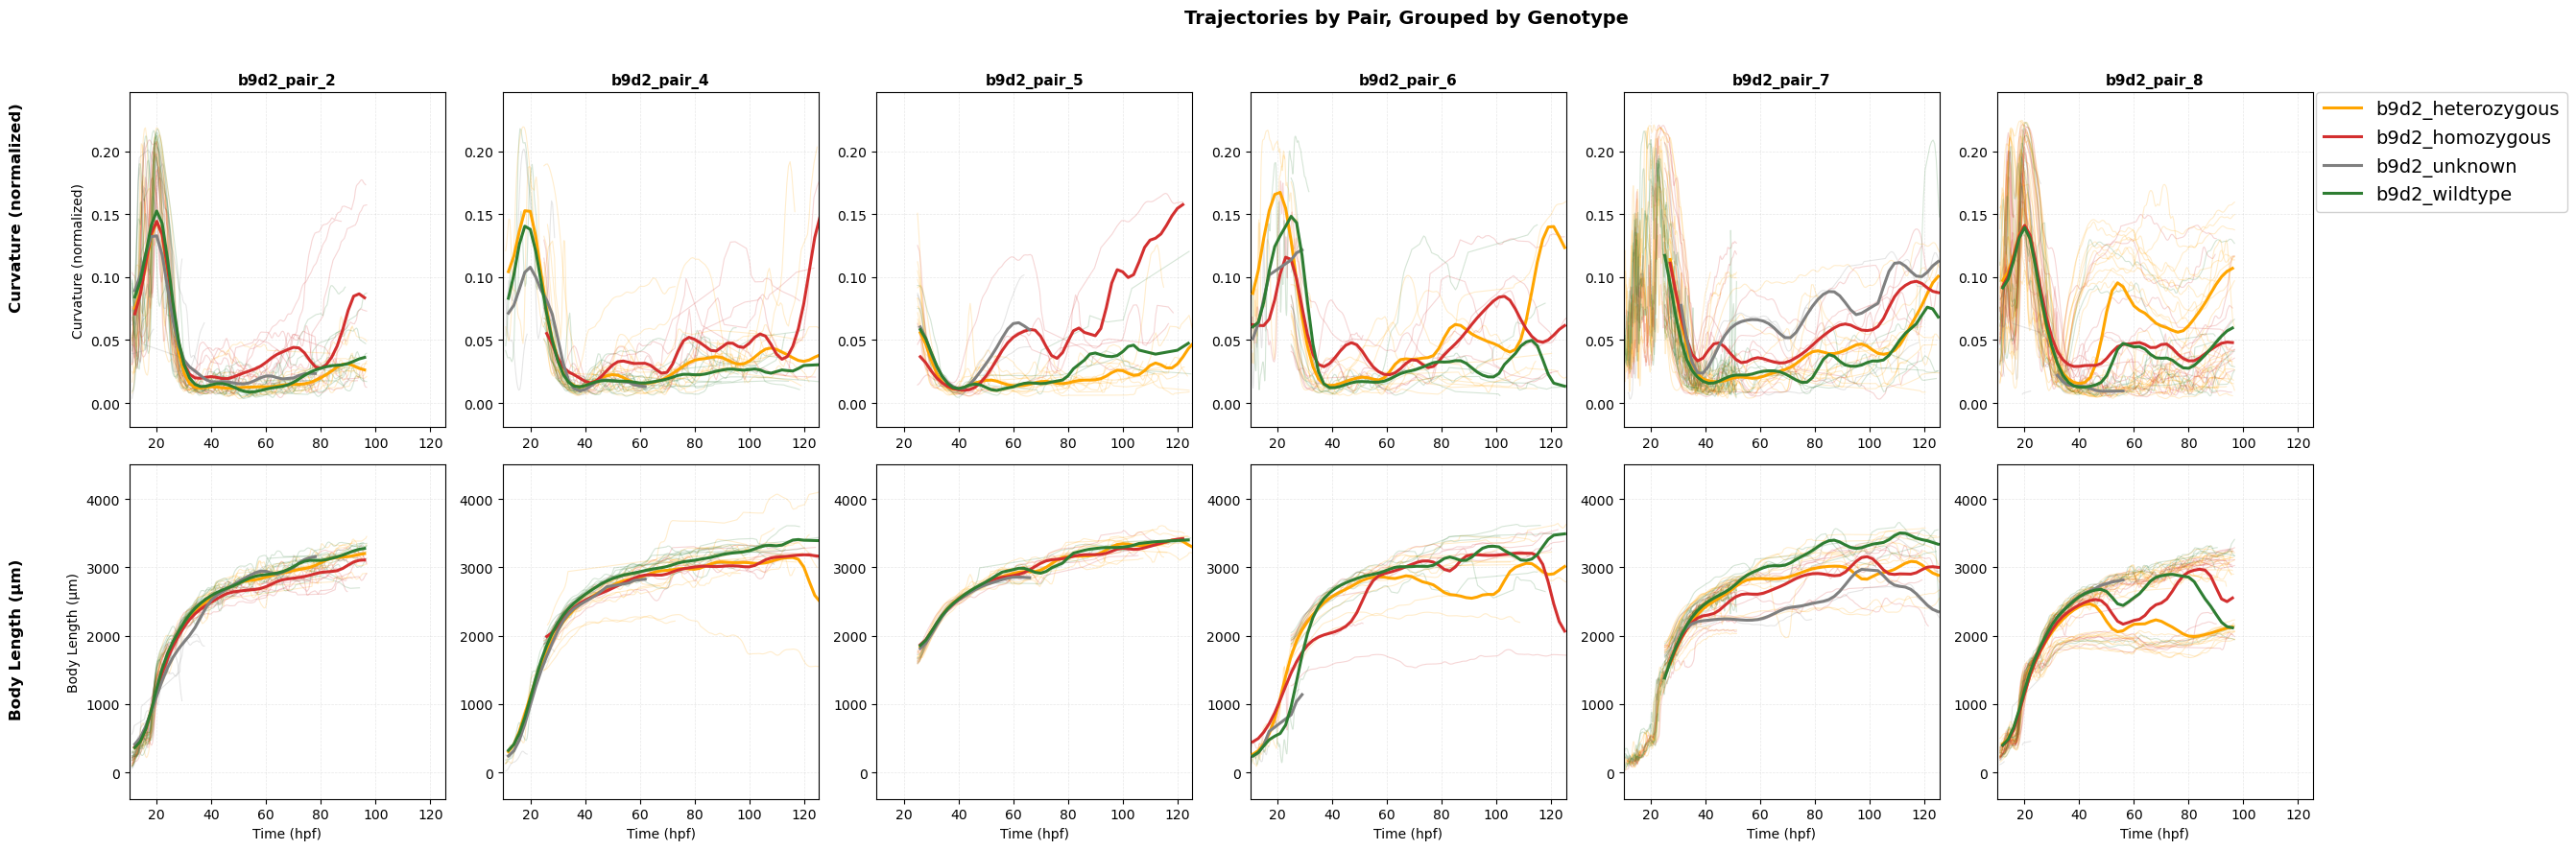

In [11]:
  
# Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

In [12]:
df_filtered = df.copy()


# Define which metrics to use
metrics = ['baseline_deviation_normalized', 'total_length_um']

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")


# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")
print(f"  Distance range: [{D[D > 0].min():.3f}, {D.max():.3f}]")

#Note to self, that this step should always go together, prepare array is an internal function only used to compute D, adidtionally i dont like how D is seprate
# from the embryo_ids. This should be fixed in future versions.


Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 217

Interpolating 2 metrics to common grid (step=0.5)


  Interpolated multi-metric shape: (32519, 5)
  Time points: 231 (10.0 - 125.0 hpf)
  Array shape: (217, 231, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.054, std=0.050
    total_length_um: mean=2409.357, std=825.596
  After normalization:
    baseline_deviation_normalized: mean=0.000000, std=1.000000
    total_length_um: mean=-0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (217, 231, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251119_A01_e01', '20251119_A02_e01', '20251119_A03_e01']... (217 total)
  Time grid: [10.  10.5 11. ]... (231 points)
Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 217
  Array shape: (217, 231, 2)
  Sakoe-Chiba radius: 3
  Processed 23650/23653 pairs (99%)...
✓ Distance matrix computed
  Shape: (217, 217)
  Distance range: [37.4801, 1102.9642]
  Max diagonal value: 0.00e+00 (should be ~0)
  Max asymmetry: 0.00e+00 (should be ~0)

✓ Distance matrix computed: (21

## Add Cluster Assignments and Membership Quality to DataFrame

In [13]:
# ============================================================================
# PHASE 1: K-SELECTION (Light Filtering)
# ============================================================================
print("="*70)
print("PHASE 1: K-SELECTION (Light Filtering)")
print("="*70)

# Step 1: Light IQR filtering (remove ~8% global outliers)
print("\nStep 1: Light IQR filtering (2.0× multiplier)...")


#NOte to self 
#function here to let you see the metrics and different thresholds would be nice. before selecting IQR, somehting like plot metirc outlier IQr Ranges. 

# Remove outliers and create clean distance matrix for Phase 1
D_phase1, embryo_ids_phase1, _ = remove_outliers_from_distance_matrix(
    D,
    embryo_ids,
    outlier_detection_method='iqr',
    outlier_threshold=2.0,
    verbose=True
)

PHASE 1: K-SELECTION (Light Filtering)

Step 1: Light IQR filtering (2.0× multiplier)...

Identifying outliers using 'iqr' method...
  Total embryos: 217
  Q1 (25th percentile): 147.039
  Q3 (75th percentile): 269.704
  IQR: 122.665
  IQR multiplier: 2.0×
  Threshold (Q3 + 2.0×IQR): 515.035
  Threshold: 515.035
  Outliers detected: 14
  Inliers retained: 203

  Outlier embryos:
    20251119_A01_e01: median_dist = 786.741
    20251119_A02_e01: median_dist = 746.202
    20251119_C04_e01: median_dist = 728.650
    20251119_D01_e01: median_dist = 839.428
    20251119_E01_e01: median_dist = 692.823
    20251121_A05_e01: median_dist = 793.415
    20251121_A07_e01: median_dist = 591.253
    20251125_D02_e01: median_dist = 742.690
    20251125_D12_e01: median_dist = 917.163
    20251125_E08_e01: median_dist = 715.465
    20251125_F04_e01: median_dist = 525.186
    20251125_F08_e01: median_dist = 647.431
    20251125_G12_e01: median_dist = 693.645
    20251125_H05_e01: median_dist = 588.671

✓ 

In [14]:
# # import sys
# from pathlib import Path

# # # Remove all cached trajectory_analysis modules
# # modules_to_remove = [
# #     'src.analyze.trajectory_analysis',
# #     'src.analyze.trajectory_analysis.k_selection',
# #     'src.analyze.trajectory_analysis.bootstrap_clustering',
# #     'src.analyze.trajectory_analysis.cluster_classification',
# #     'src.analyze.trajectory_analysis.dendrogram',
# #     'src.analyze.trajectory_analysis.plotting',
# # ]

# # for module in modules_to_remove:
# #     if module in sys.modules:
# #         del sys.modules[module]
# #         print(f"Removed: {module}")

# # # Now import fresh
# from src.analyze.trajectory_analysis.k_selection import run_k_selection_with_plots
# from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe

# print("✓ Successfully reimported all modules!")


# print(f"Loaded {len(embryo_ids)} embryos")
# print(f"Distance matrix shape: {D.shape}")
# print(f"Trajectory data: {len(df)} rows")

# results = run_k_selection_with_plots(
#     df=df_filtered,
#     D=D,
#     embryo_ids=embryo_ids,
#     output_dir=Path('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/k_selection'),
#     plotting_metrics=['baseline_deviation_normalized', 'total_length_um'],
#     k_range=[2, 3, 4, 5, 6],
#     n_bootstrap=100
# )


In [15]:
# Reload the trajectory_analysis module to pick up changes
import sys

modules_to_remove = [
    'src.analyze.trajectory_analysis',
]
for module in list(sys.modules.keys()):
    if module.startswith('src.analyze.trajectory_analysis'):
        del sys.modules[module]

# Re-import with new K-medoids functionality
from src.analyze.trajectory_analysis import (
    run_k_selection_with_plots,
    run_bootstrap_kmedoids,
    run_bootstrap_hierarchical,
)

# Test 1: Quick test that K-medoids function is available
print("✓ run_bootstrap_kmedoids imported successfully")

# Test 2: Run k-selection with K-medoids
# Assuming you have: df, D (distance matrix), embryo_ids already defined
k_results_kmedoids = run_k_selection_with_plots(
    df=df,
    D=D,
    embryo_ids=embryo_ids,
    output_dir=Path('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/kmedoids_k_selection_all_b9d2_data'),
    k_range=[2, 3, 4, 5,6,7],  # Start small for testing
    n_bootstrap=100,      # Fewer iterations for quick test
    method='kmedoids',   # NEW!
    verbose=True
)


✓ run_bootstrap_kmedoids imported successfully
K SELECTION WITH TRAJECTORY PLOTS
Output directory: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/kmedoids_k_selection_all_b9d2_data
Clustering method: kmedoids
Plotting metrics: ['baseline_deviation_normalized', 'total_length_um']
K range: [2, 3, 4, 5, 6, 7]

Evaluating k=2 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 174/217 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=2 Summary:
  Core: 215 (99.1%)
  Uncertain: 2 (0.9%)
  Outlier: 0 (0.0%)
  Mean max_p: 0.988
  Mean entropy: 0.053
  Silhouette: 0.558

Evaluating k=3 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 174/217 samples per iteration
  Progress: 10/100
  

In [16]:
# Access best k
# best_k = results['best_k']  # e.g., 3
results = k_results_kmedoids

best_k  = 2 

print(f"best k is {best_k}")

# Get quality metrics for best k
quality = results['clustering_by_k'][best_k]['quality']
print(f"Core: {quality['pct_core']:.1f}%")
print(f"Silhouette: {quality['silhouette']:.3f}")

# Get cluster assyou ignment for embryo at best k
embryo_to_cluster = results['clustering_by_k'][best_k]['assignments']['embryo_to_cluster']



# Check membership quality
# embryo_to_membership_quality = results['clustering_by_k'][best_k]['membership']['embryo_to_membership_quality']
# membership_quality = embryo_to_membership_quality['20251119_G07_E008']  # 'core', 'uncertain', or 'outlier'

# Compare across k values using summary
print(results['summary_df'])

# Add clustering results to DataFrame
df_filtered['cluster_on_all_b9d2_experiments'] = df_filtered['embryo_id'].map(embryo_to_cluster)


# df_filtered['membership_quality'] = df_filtered['embryo_id'].map(embryo_to_membership_quality)

# Verify
print(df_filtered[['embryo_id', 'cluster_on_all_b9d2_experiments']].drop_duplicates())
print(f"\nCluster distribution:")
print(df_filtered['cluster_on_all_b9d2_experiments'].value_counts().sort_index())
# print(f"\nMembership quality distribution:")
# print(df_filtered['membership_quality'].value_counts())


best k is 2
Core: 99.1%
Silhouette: 0.558
   k   pct_core  pct_uncertain  pct_outlier  mean_max_p  mean_entropy  \
0  2  99.078341       0.921659     0.000000    0.988061      0.053227   
1  3  74.193548      24.884793     0.921659    0.856141      0.526617   
2  4  47.465438      49.769585     2.764977    0.769901      0.705704   
3  5  44.700461      50.230415     5.069124    0.770381      0.771831   
4  6  39.631336      52.073733     8.294931    0.752987      0.904409   
5  7  45.622120      45.161290     9.216590    0.770890      0.923413   

   silhouette  
0    0.557557  
1    0.551377  
2    0.233658  
3    0.210626  
4    0.206400  
5    0.223381  
              embryo_id  cluster_on_all_b9d2_experiments
0      20251119_A01_e01                                1
107    20251119_A02_e01                                1
155    20251119_A03_e01                                1
455    20251119_A04_e01                                1
723    20251119_A05_e01                          

Unique embryos per cluster:
cluster_on_all_b9d2_experiments
0    164
1     53
Name: count, dtype: int64


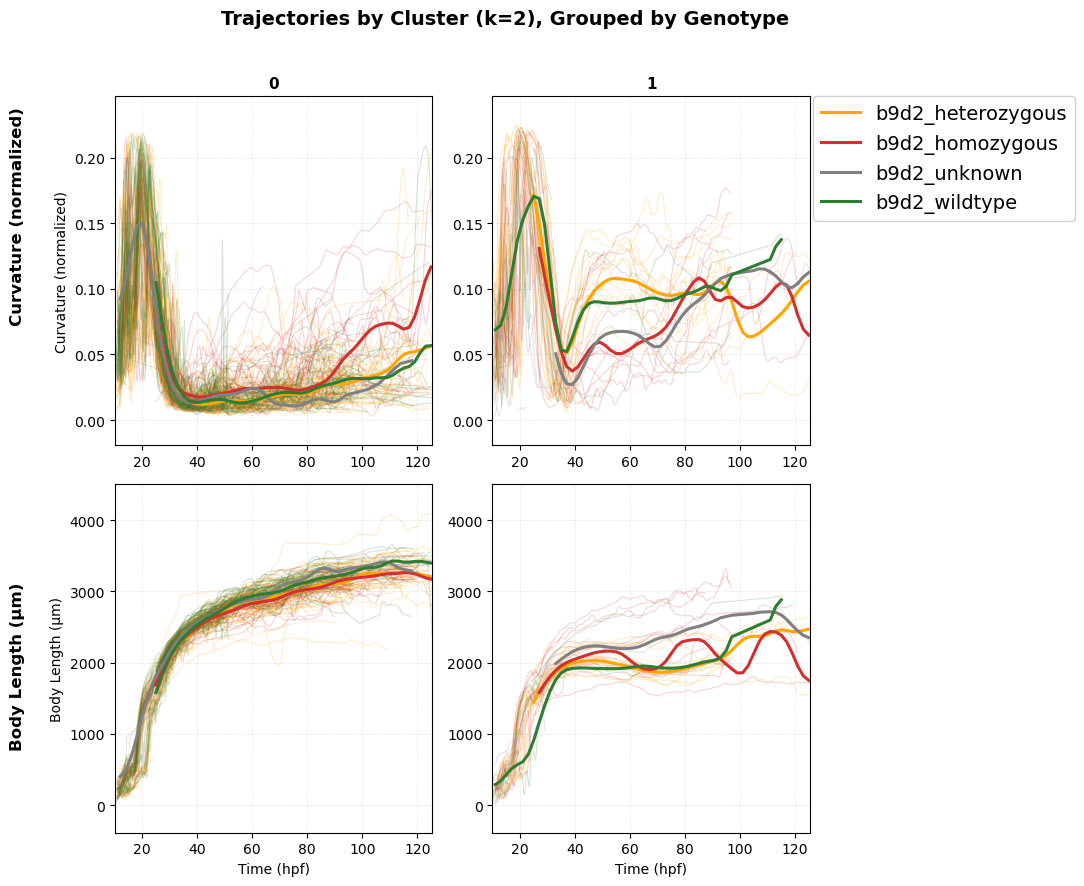

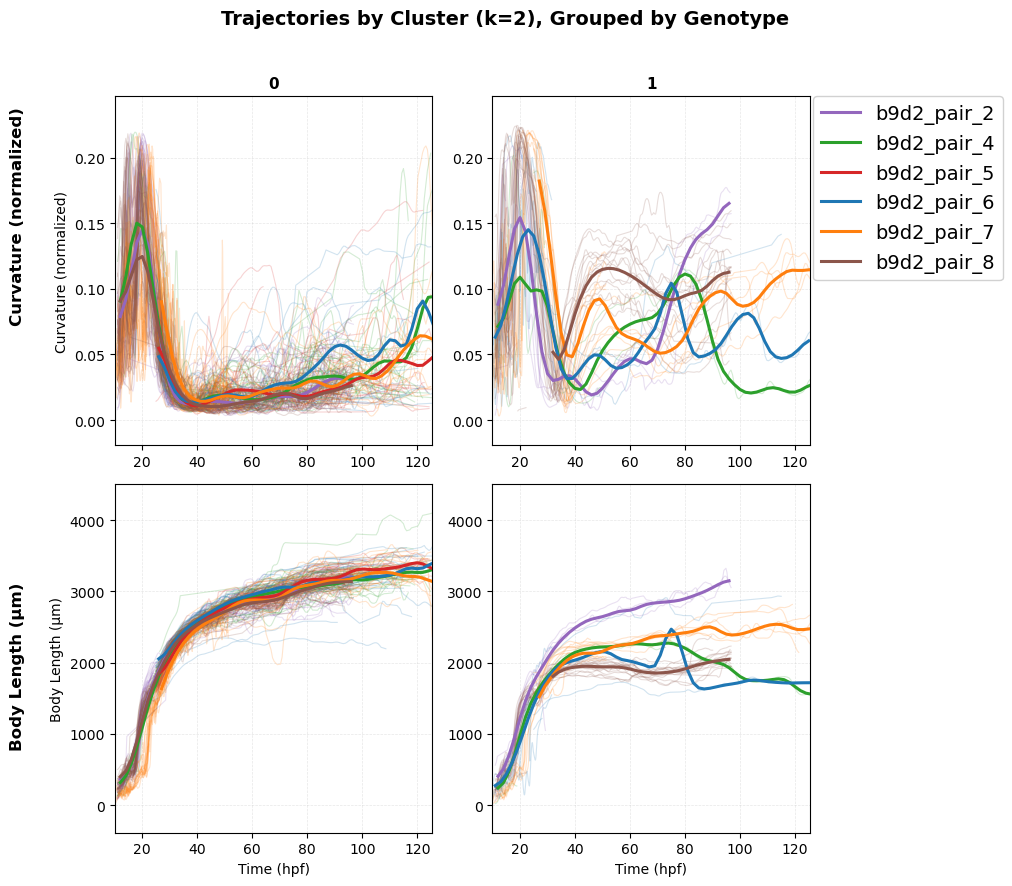

In [ ]:
# Count embryos per cluster
import sys

modules_to_remove = [
    'src.analyze.trajectory_analysis',
    'src.analyze.trajectory_analysis.facetted_plotting',
]
for module in list(sys.modules.keys()):
    if module.startswith('src.analyze.trajectory_analysis'):
        del sys.modules[module]

# Re-import
from src.analyze.trajectory_analysis.facetted_plotting import plot_multimetric_trajectories


embryos_per_cluster = df_filtered.drop_duplicates(subset=['embryo_id'])['cluster_on_all_b9d2_experiments'].value_counts().sort_index()
print("Unique embryos per cluster:")
print(embryos_per_cluster)


fig_by_genotype = plot_multimetric_trajectories(
    df_filtered,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_all_b9d2_experiments',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_all_b9d2_experiments',
    color_by_grouping='pair',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

In [18]:
cluster_to_embryos = results['clustering_by_k'][best_k]['assignments']['cluster_to_embryos']

# Define output directory
output_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists')
output_dir.mkdir(parents=True, exist_ok=True)


# Define phenotypes
phenotypes = {
    1: 'CE-phenotype',
    0: 'NOT_CE',
}

# Save each phenotype to a file
for cluster_id, phenotype_name in phenotypes.items():
    embryo_list = cluster_to_embryos[cluster_id]

    # Save as text file (one embryo per line)
    output_file = output_dir / f'{phenotype_name}.txt'
    with open(output_file, 'w') as f:
        for embryo_id in embryo_list:
            f.write(f"{embryo_id}\n")

    print(f"✓ Saved {phenotype_name}: {len(embryo_list)} embryos → {output_file}")


✓ Saved CE-phenotype: 53 embryos → results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists/CE-phenotype.txt
✓ Saved NOT_CE: 164 embryos → results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists/NOT_CE.txt


# We've choosen CE luster using kmedioid clustering no we subcluster and evaluate.  

note: we have to remove 20251119 (and 20251104) from this anlayss of the HTA phenotype because it apears roughtly after 60

In [47]:
df_filtered_no_CE = df_filtered[df_filtered['cluster_on_all_b9d2_experiments'] == 0].copy() # the other embryos are poor quality tracks

df_filtered_no_CE = df_filtered_no_CE[df_filtered_no_CE["experiment_id"]!= "20251119"]

df_filtered_no_CE["experiment_id"].unique()

for experiment in df_filtered_no_CE["experiment_id"].unique():
    exper_df = df_filtered_no_CE[df_filtered_no_CE["experiment_id"] == experiment]
    time_range = exper_df['predicted_stage_hpf'].agg(['min', 'max'])
    print(f"{experiment}: {time_range['min']:.1f} - {time_range['max']:.1f} hpf")



20251121: 25.0 - 125.4 hpf
20251125: 11.0 - 96.7 hpf


In [48]:
# Prepare multivariate array

df_time_filtered_no_CE = df_filtered_no_CE[
    (df_filtered_no_CE['predicted_stage_hpf'] >= 25) & 
    (df_filtered_no_CE['predicted_stage_hpf'] <= 96.7)
].copy()


X_no_CE, embryo_ids_no_CE, time_grid = prepare_multivariate_array(
    df_time_filtered_no_CE,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")


# Compute MD-DTW distance matrix
D_no_CE = compute_md_dtw_distance_matrix(
    X_no_CE,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D_no_CE.shape}")
print(f"  Distance range: [{D_no_CE[D_no_CE > 0].min():.3f}, {D_no_CE.max():.3f}]")

#Note to self, that this step should always go together, prepare array is an internal function only used to compute D, adidtionally i dont like how D is seprate
# from the embryo_ids. This should be fixed in future versions.


Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 147

Interpolating 2 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (19516, 5)
  Time points: 144 (25.0 - 96.5 hpf)
  Array shape: (147, 144, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.026, std=0.022
    total_length_um: mean=2786.083, std=381.563
  After normalization:
    baseline_deviation_normalized: mean=-0.000000, std=1.000000
    total_length_um: mean=-0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (217, 231, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251125_B06_e01' '20251125_F09_e01' '20251125_G06_e01']... (5 total)
  Time grid: [25.  25.5 26. ]... (144 points)
Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 147
  Array shape: (147, 144, 2)
  Sakoe-Chiba radius: 3
  Processed 10870/10878 pairs (99%)...
✓ Distance 

In [49]:
results_k_medoids_no_CE = run_k_selection_with_plots(
    df=df_filtered_no_CE,
    D=D_no_CE,
    embryo_ids=embryo_ids_no_CE,
    output_dir=Path('results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids/'),
    plotting_metrics=['baseline_deviation_normalized', 'total_length_um'],
    k_range=[2, 3, 4, 5, 6, 7],
    n_bootstrap=100,
    method='kmedoids', 
)


results_hierarchical_no_CE = run_k_selection_with_plots(
    df=df_filtered_no_CE,
    D=D_no_CE,
    embryo_ids=embryo_ids_no_CE,
    output_dir=Path('results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_mediods'),
    plotting_metrics=['baseline_deviation_normalized', 'total_length_um'],
    k_range=[2, 3, 4, 5, 6, 7],
    n_bootstrap=100,
    method='hierarchical', 
)

K SELECTION WITH TRAJECTORY PLOTS
Output directory: results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids
Clustering method: kmedoids
Plotting metrics: ['baseline_deviation_normalized', 'total_length_um']
K range: [2, 3, 4, 5, 6, 7]

Evaluating k=2 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 118/147 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100


  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=2 Summary:
  Core: 115 (78.2%)
  Uncertain: 32 (21.8%)
  Outlier: 0 (0.0%)
  Mean max_p: 0.884
  Mean entropy: 0.415
  Silhouette: 0.312

Evaluating k=3 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 118/147 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=3 Summary:
  Core: 80 (54.4%)
  Uncertain: 59 (40.1%)
  Outlier: 8 (5.4%)
  Mean max_p: 0.798
  Mean entropy: 0.699
  Silhouette: 0.154

Evaluating k=4 (method=kmedoids)
Running 100 bootstrap iterations (K-medoids)...
  Sampling 118/147 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100

In [50]:
import numpy as np
import pickle
from pathlib import Path

# Create output directory
data_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/data')
data_dir.mkdir(parents=True, exist_ok=True)

# Save everything in one comprehensive pickle file
with open(data_dir / 'clustering_data_full.pkl', 'wb') as f:
    pickle.dump({
        # Distance matrix & array
        'D': D,
        'X': X,
        'embryo_ids': embryo_ids,
        'time_grid': time_grid,
        'metrics': metrics,
        
        # Trajectory DataFrame (most important!)
        'df_filtered': df_filtered,
        
        # Optional: Save the "no CE" versions too
        'D_no_CE': D_no_CE,
        'X_no_CE': X_no_CE,
        'embryo_ids_no_CE': embryo_ids_no_CE,
        'df_filtered_no_CE': df_filtered_no_CE,
    }, f)

# Also save df_filtered separately as parquet (faster/smaller than CSV)
df_filtered.to_parquet(data_dir / 'df_filtered.parquet', index=False)
df_filtered_no_CE.to_parquet(data_dir / 'df_filtered_no_CE.parquet', index=False)

print(f"✓ Saved to {data_dir}")
print(f"  - clustering_data_full.pkl ({(D.nbytes + X.nbytes) / 1e6:.1f} MB arrays)")
print(f"  - df_filtered.parquet ({len(df_filtered)} rows)")
print(f"  - df_filtered_no_CE.parquet ({len(df_filtered_no_CE)} rows)")

✓ Saved to results/mcolon/20251219_b9d2_phenotype_extraction/data
  - clustering_data_full.pkl (1.2 MB arrays)
  - df_filtered.parquet (31160 rows)
  - df_filtered_no_CE.parquet (17233 rows)


In [ ]:
import pickle
import pandas as pd
from pathlib import Path

data_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/data')

# Option 1: Load everything from pickle
with open(data_dir / 'clustering_data_full.pkl', 'rb') as f:
    data = pickle.load(f)
    D = data['D']
    X = data['X']
    embryo_ids = data['embryo_ids']
    df_filtered = data['df_filtered']
    # ... etc

# Option 2: Load just the DataFrames (fastest)
df_filtered = pd.read_parquet(data_dir / 'df_filtered.parquet')
df_filtered_no_CE = pd.read_parquet(data_dir / 'df_filtered_no_CE.parquet')

print(f"✓ Loaded: {len(df_filtered)} rows, {df_filtered['embryo_id'].nunique()} embryos")

In [51]:
# Add this function to your notebook (or later to k_selection.py)

plot_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids')

def plot_cluster_flow(
    results,
    k_range=None,
    title="Cluster Flow Across k Values",
    output_path=None,
    color_palette=None,
):
    """
    Create a Sankey diagram showing how clusters split as k increases.
    
    Parameters
    ----------
    results : Dict
        Output from run_k_selection_with_plots() or evaluate_k_range().
        Must contain 'clustering_by_k' with assignments for each k.
    k_range : List[int], optional
        Which k values to include. If None, uses all available k values.
    title : str
        Plot title.
    output_path : Path, optional
        If provided, saves the plot as HTML.
    color_palette : List[str], optional
        Colors for clusters.
    
    Returns
    -------
    plotly.graph_objects.Figure
    
    Examples
    --------
    >>> fig = plot_cluster_flow(results, k_range=[2, 3, 4, 5])
    >>> fig.show()
    """
    import plotly.graph_objects as go
    
    clustering_by_k = results['clustering_by_k']
    
    # Determine k values to use
    if k_range is None:
        k_range = sorted(clustering_by_k.keys())
    else:
        k_range = [k for k in k_range if k in clustering_by_k]
    
    if len(k_range) < 2:
        raise ValueError("Need at least 2 k values to create a flow diagram")
    
    # Default color palette
    if color_palette is None:
        color_palette = [
            "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        ]
    
    def hex_to_rgba(hex_color, alpha=0.5):
        hex_color = hex_color.lstrip('#')
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        return f"rgba({r}, {g}, {b}, {alpha})"
    
    # Build node labels and indices
    node_labels = []
    node_colors = []
    node_index = {}  # Maps (k, cluster_id) -> index
    
    for k in k_range:
        cluster_to_embryos = clustering_by_k[k]['assignments']['cluster_to_embryos']
        n_clusters = len(cluster_to_embryos)
        for c in range(n_clusters):
            idx = len(node_labels)
            node_index[(k, c)] = idx
            n_embryos = len(cluster_to_embryos.get(c, []))
            node_labels.append(f"k={k}: C{c} (n={n_embryos})")
            node_colors.append(color_palette[c % len(color_palette)])
    
    # Build links (flows between consecutive k values)
    sources = []
    targets = []
    values = []
    link_colors = []
    
    for i in range(len(k_range) - 1):
        k_from = k_range[i]
        k_to = k_range[i + 1]
        
        # Get cluster assignments for both k values
        assignments_from = clustering_by_k[k_from]['assignments']['embryo_to_cluster']
        assignments_to = clustering_by_k[k_to]['assignments']['embryo_to_cluster']
        
        # Count embryos flowing from each cluster at k_from to each cluster at k_to
        flow_counts = {}  # (cluster_from, cluster_to) -> count
        
        for embryo_id, cluster_from in assignments_from.items():
            if embryo_id in assignments_to:
                cluster_to = assignments_to[embryo_id]
                key = (cluster_from, cluster_to)
                flow_counts[key] = flow_counts.get(key, 0) + 1
        
        # Add links
        for (cluster_from, cluster_to), count in flow_counts.items():
            sources.append(node_index[(k_from, cluster_from)])
            targets.append(node_index[(k_to, cluster_to)])
            values.append(count)
            link_colors.append(hex_to_rgba(color_palette[cluster_from % len(color_palette)], 0.5))
    
    # Create Sankey figure
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=node_labels,
            color=node_colors,
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
        )
    )])
    
    fig.update_layout(
        title_text=title,
        font_size=12,
        height=400 + 50 * len(k_range),
        width=250 * len(k_range),
    )
    
    if output_path:
        from pathlib import Path
        fig.write_html(str(output_path))
        print(f"✓ Saved cluster flow diagram: {output_path}")
    
    return fig


# Usage in your notebook:
fig = plot_cluster_flow(
    results_k_medoids_no_CE,
    # k_range=[2, 3, 4, 5, 6],
    title="B9D2 Cluster Flow: How Clusters Split as k Increases",
    output_path=plot_dir / "cluster_flow_sankey.html"
)
fig.show()

✓ Saved cluster flow diagram: results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids/cluster_flow_sankey.html


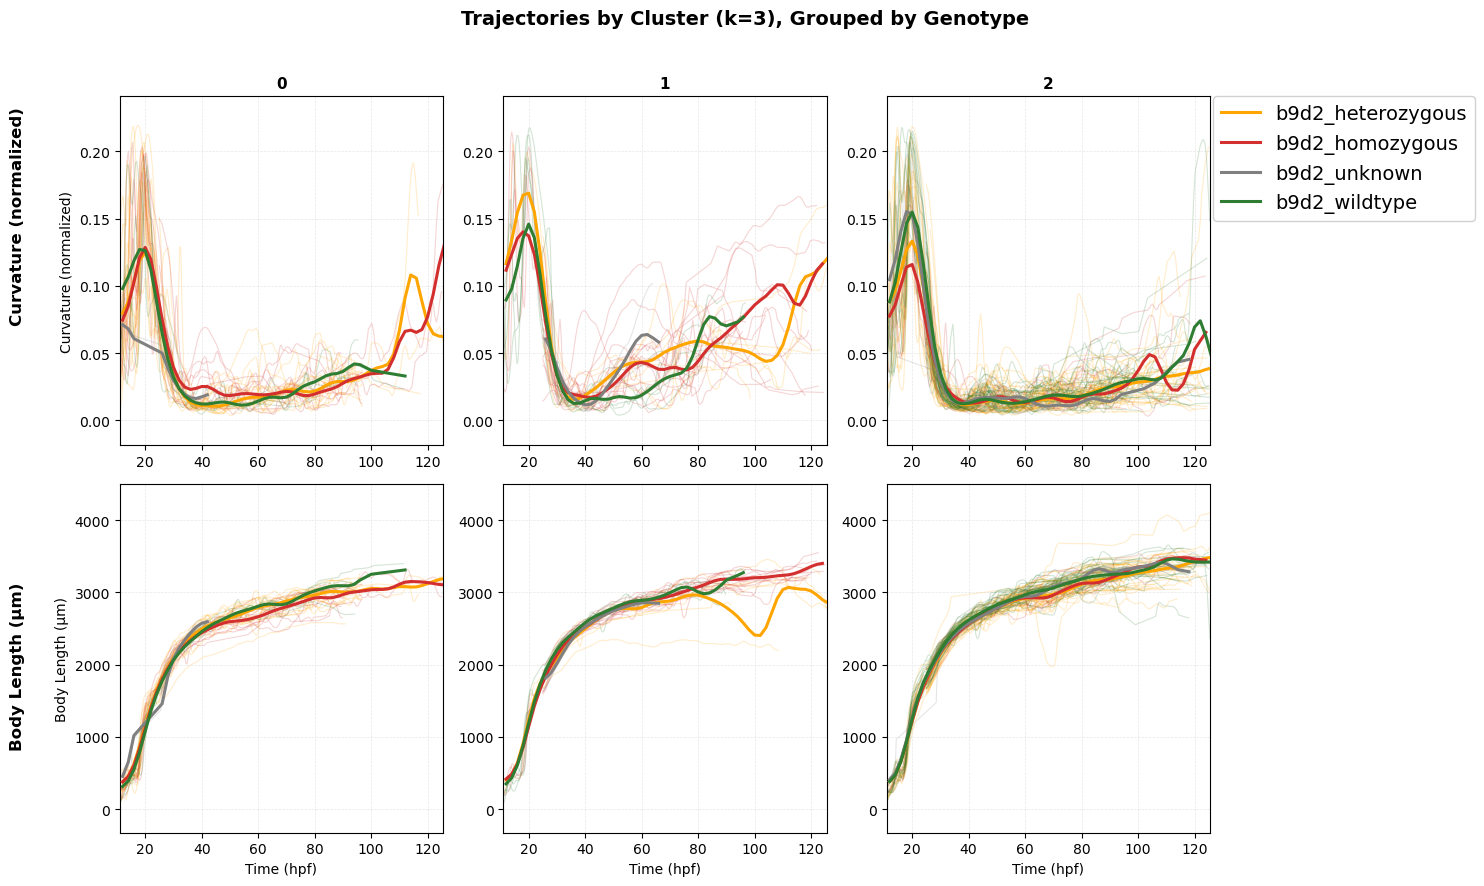

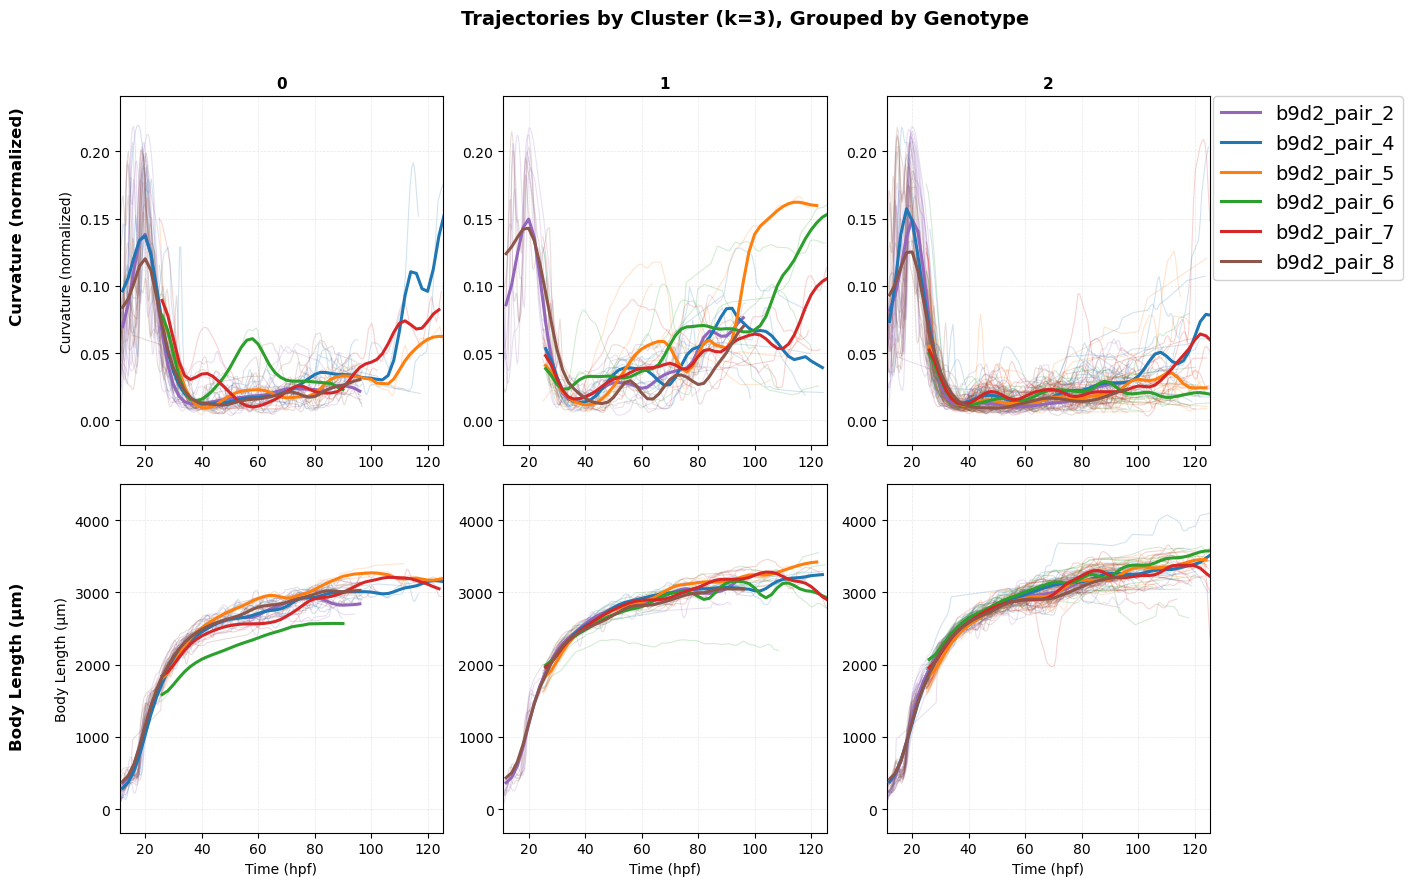

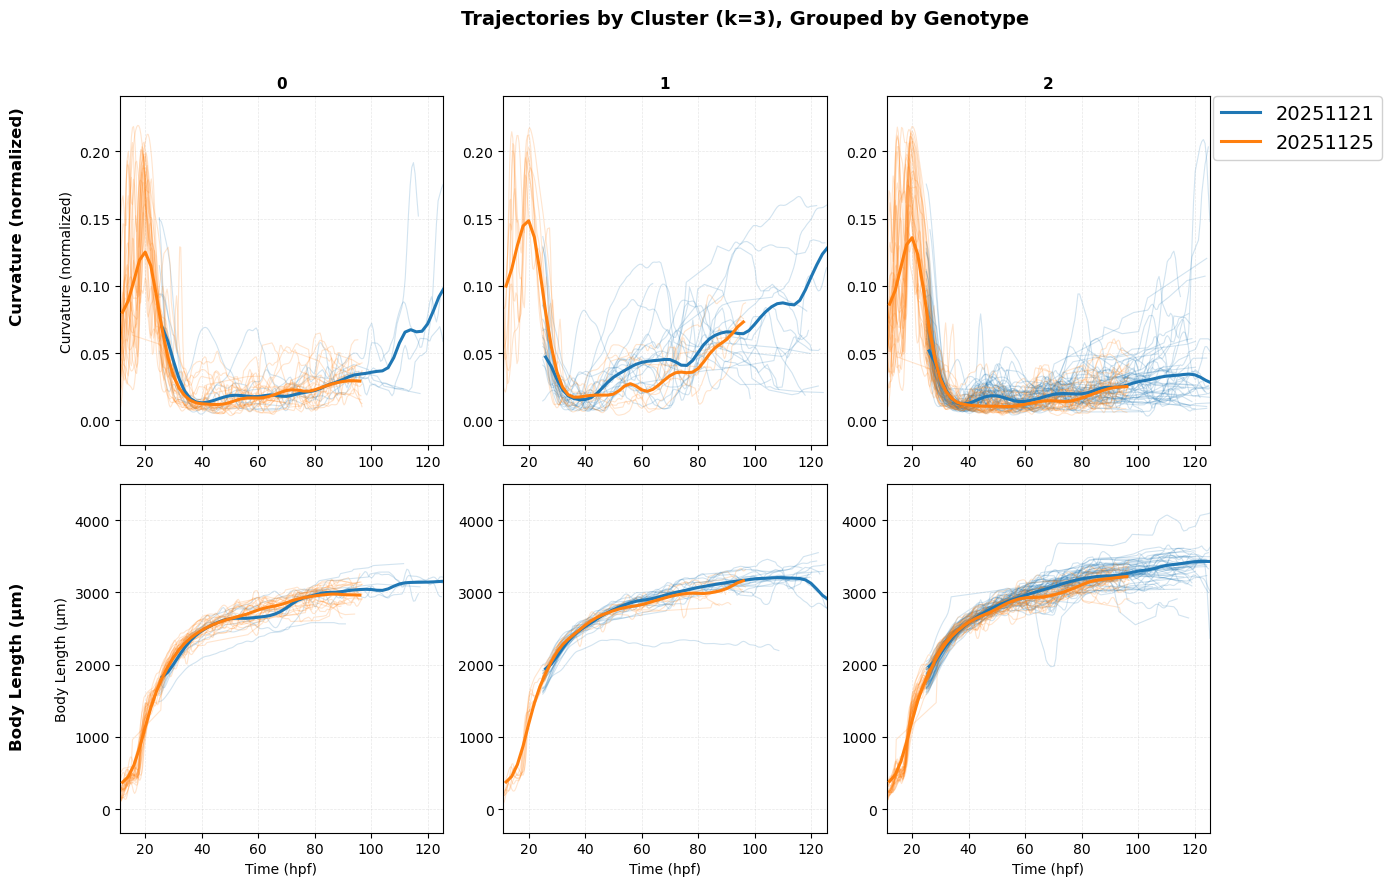

In [52]:
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids")

choosen_k = 3

embryo_to_cluster = results_k_medoids_no_CE['clustering_by_k'][choosen_k]['assignments']['embryo_to_cluster']


cluster_to_embryos = results_k_medoids_no_CE['clustering_by_k'][choosen_k]['assignments']['cluster_to_embryos']


df_filtered_no_CE['cluster_on_b9d2_no_CE'] = df_filtered_no_CE['embryo_id'].map(embryo_to_cluster)


fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_genotype_kmedoids.html',
)

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='pair',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_cluster_kmedoids.html',
)


fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='experiment_id',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_experiment_id_kmedoids.html',
)

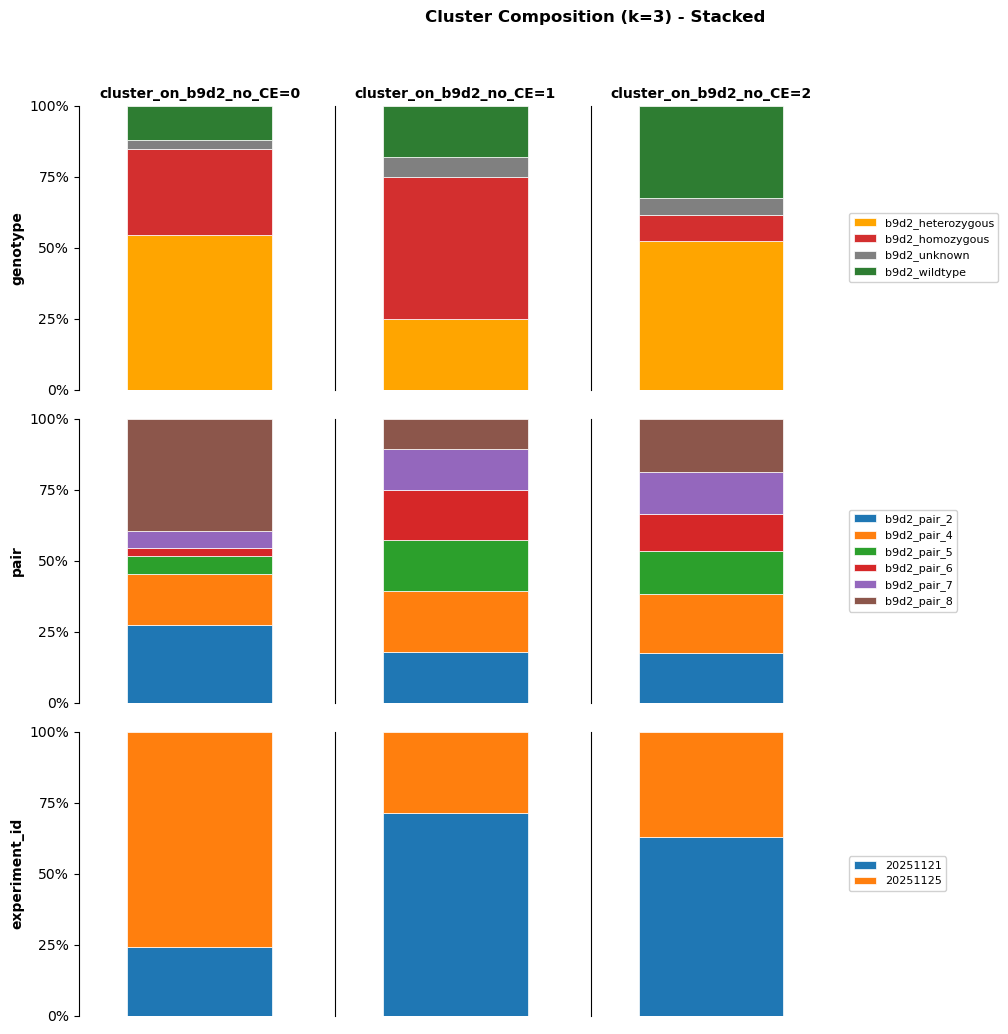

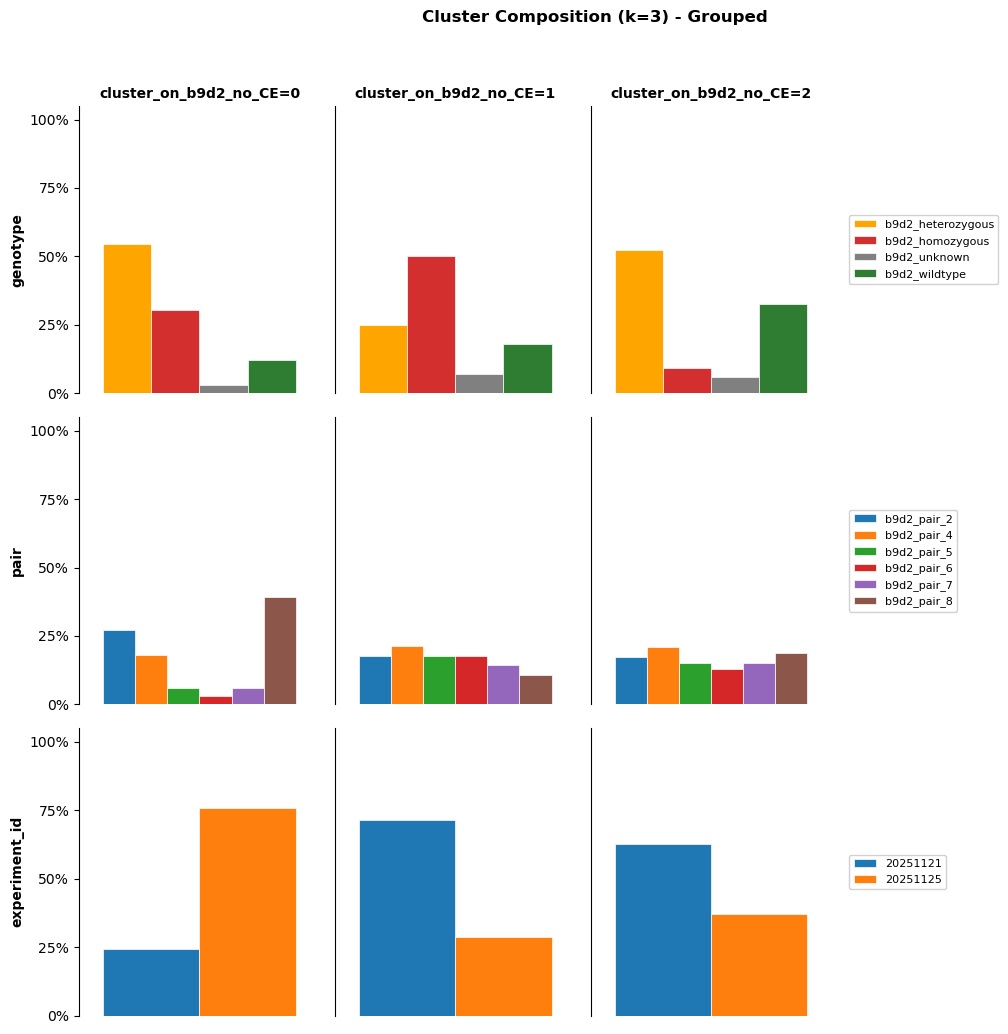

In [54]:
# Reload
import sys
for module in list(sys.modules.keys()):
    if module.startswith('src.analyze.trajectory_analysis'):
        del sys.modules[module]

from src.analyze.trajectory_analysis.facetted_plotting import plot_proportion_grid

# Stacked (default)
fig_stacked = plot_proportion_grid(
    df_filtered_no_CE,
    col_by='cluster_on_b9d2_no_CE',
    row_by=['genotype', 'pair', 'experiment_id'],
    count_by='embryo_id',
    bar_mode='stacked',
    title=f'Cluster Composition (k={best_k}) - Stacked',
    output_path=plot_dir / 'cluster_composition_stacked.png',
)

# Grouped (side-by-side)
fig_grouped = plot_proportion_grid(
    df_filtered_no_CE,
    col_by='cluster_on_b9d2_no_CE',
    row_by=['genotype', 'pair', 'experiment_id'],
    count_by='embryo_id',
    bar_mode='grouped',
    title=f'Cluster Composition (k={best_k}) - Grouped',
    output_path=plot_dir / 'cluster_composition_grouped.png',
)


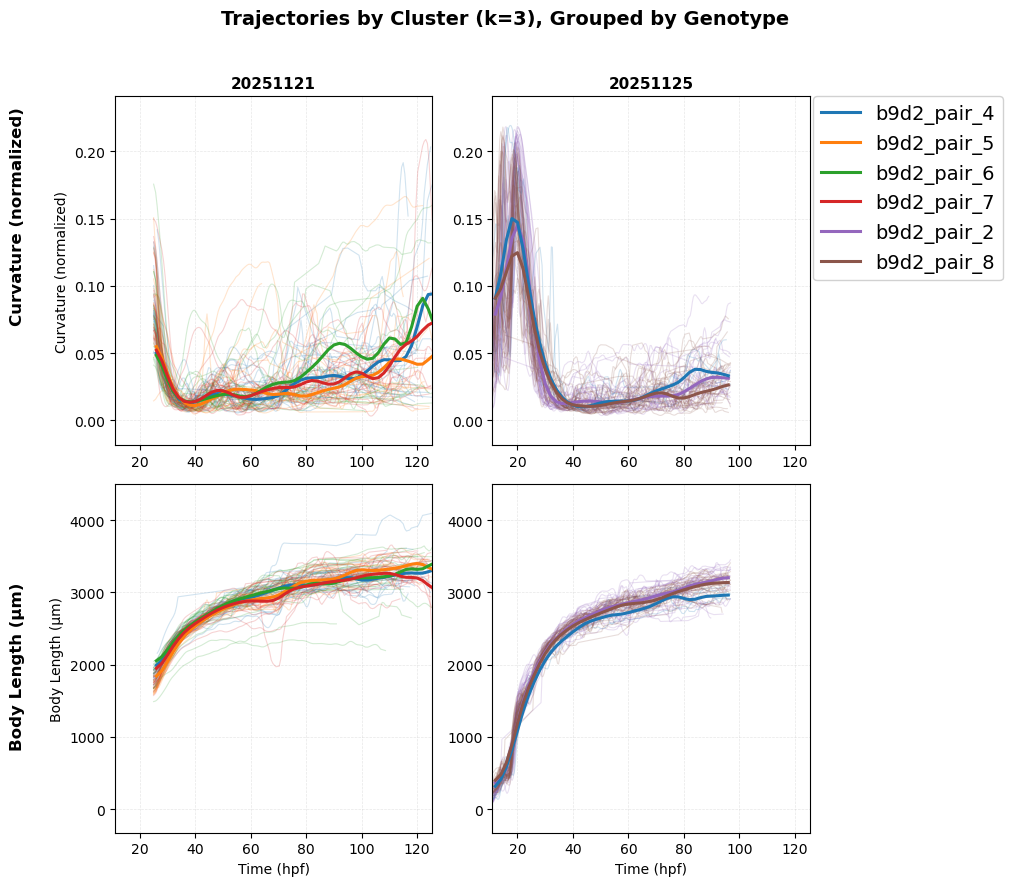

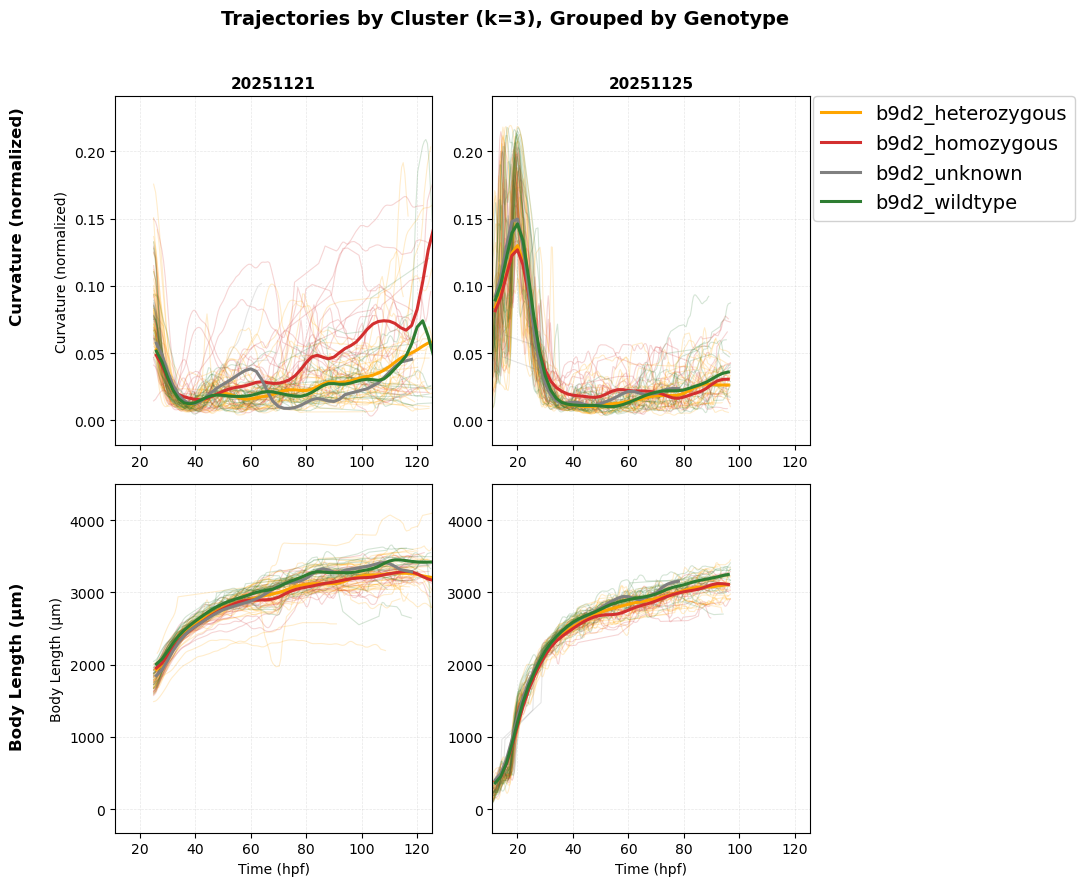

In [55]:

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='experiment_id',
    color_by_grouping='pair',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='matplotlib',
    # output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_cluster_kmedoids.html',
)

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='experiment_id',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='matplotlib',
    # output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_cluster_kmedoids.html',
)

Lets look into the penetrant cluster 1 to extract the HTA phenotype embryos.

In [57]:
# 1) Filter: penetrant cluster 1 + drop unknown genotypes
df_for_plotting = df_filtered_no_CE.loc[
    (df_filtered_no_CE["cluster_on_b9d2_no_CE"] == 1)
    & (~df_filtered_no_CE["genotype"].astype(str).str.contains("unknown", case=False, na=False))
].copy()

# (Optional) sanity check
print(df_for_plotting[["genotype", "pair"]].value_counts().head(20))

# 2) Plot
plot_trajectories_faceted(
    df_for_plotting,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="pair",
    color_by_grouping="genotype",
    output_path=plot_dir / "b9d2_no_CE_curvature_by_penetrant_cluster_1_pairXgenotype_trajectories.html",
# 1) Filter: penetrant cluster 1 + drop unknown genotypes
df_for_plotting = df_filtered_no_CE.loc[
    (df_filtered_no_CE["cluster_on_b9d2_no_CE"] == 1)
    & (~df_filtered_no_CE["genotype"].astype(str).str.contains("unknown", case=False, na=False))
].copy()

# (Optional) sanity check
print(df_for_plotting[["genotype", "pair"]].value_counts().head(20))

# 2) Plot
plot_trajectories_faceted(
    df_for_plotting,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="pair",
    color_by_grouping="genotype",
    output_path=plot_dir / "b9d2_no_CE_curvature_by_penetrant_cluster_1_pairXgenotype_trajectories.html",
))

genotype           pair       
b9d2_wildtype      b9d2_pair_2    494
b9d2_homozygous    b9d2_pair_5    314
                   b9d2_pair_6    310
                   b9d2_pair_8    299
                   b9d2_pair_4    273
b9d2_heterozygous  b9d2_pair_6    262
                   b9d2_pair_7    248
b9d2_homozygous    b9d2_pair_7    231
                   b9d2_pair_2    156
b9d2_heterozygous  b9d2_pair_2    148
                   b9d2_pair_4    142
b9d2_wildtype      b9d2_pair_8    116
                   b9d2_pair_4     70
Name: count, dtype: int64



=== PAIR: b9d2_pair_2 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (1): ['20251125_G03_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (1): ['20251125_A04_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (3): ['20251125_C01_e01', '20251125_C03_e01', '20251125_F05_e01']

=== PAIR: b9d2_pair_4 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (2): ['20251121_G01_e01', '20251121_H03_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (3): ['20251121_C05_e01', '20251121_D03_e01', '20251121_G02_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (1): ['20251121_H01_e01']

=== PAIR: b9d2_pair_5 ===
  Genotype: b9d2_homozygous
    Embryo IDs (3): ['20251121_E06_e01', '20251121_F04_e01', '20251121_G05_e01']

=== PAIR: b9d2_pair_6 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (2): ['20251121_B09_e01', '20251121_D07_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (3): ['20251121_A09_e01', '20251121_E08_e01', '20251121_F08_e01']

=== PAIR: b9d2_pair_7 ===
  Genotype: b9d2_heterozygous
    Embryo I

lets look into cluster 0 which seems to have an enrichment of heteroyzygotes and some homozygous embryos. 

ill particualrly be looking for mutants that have a subtle HTA phenotype  also interested why theres an enrichment for hets in this cluster 

In [ ]:
# 1) Filter: penetrant cluster 1 + drop unknown genotypes
df_for_plotting = df_filtered_no_CE.loc[
    (df_filtered_no_CE["cluster_on_b9d2_no_CE"] == 0)
    & (~df_filtered_no_CE["genotype"].astype(str).str.contains("unknown", case=False, na=False))
].copy()

# (Optional) sanity check
# print(df_for_plotting[["genotype", "pair"]].value_counts().head(20))


for pair in sorted(df_for_plotting["pair"].dropna().unique()):
    print(f"\n=== PAIR: {pair} cluster 0 ===")

    df_pair = df_for_plotting[df_for_plotting["pair"] == pair]

    for genotype in sorted(df_pair["genotype"].dropna().unique()):
        embryo_ids = (
            df_pair.loc[df_pair["genotype"] == genotype, "embryo_id"]
            .dropna()
            .unique()
        )

        print(f"  Genotype: {genotype}")
        print(f"    Embryo IDs ({len(embryo_ids)}): {list(embryo_ids)}")
# 2) Plot
plot_trajectories_faceted(
    df_for_plotting,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="pair",
    color_by_grouping="genotype",
    output_path=plot_dir / "b9d2_no_CE_curvature_by_penetrant_cluster_0_pairXgenotype_trajectories.html",
)



=== PAIR: b9d2_pair_2 cluster 0 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (3): ['20251125_F01_e01', '20251125_H01_e01', '20251125_H03_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (4): ['20251125_A01_e01', '20251125_D04_e01', '20251125_E04_e01', '20251125_E05_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (2): ['20251125_B05_e01', '20251125_D05_e01']

=== PAIR: b9d2_pair_4 cluster 0 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (4): ['20251121_F01_e01', '20251121_F02_e01', '20251125_E12_e01', '20251125_H12_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (1): ['20251121_D01_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (1): ['20251125_F12_e01']

=== PAIR: b9d2_pair_5 cluster 0 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (1): ['20251121_H04_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (1): ['20251121_C04_e01']

=== PAIR: b9d2_pair_6 cluster 0 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (1): ['20251121_D08_e01']

=== PAIR: b9d2_pair_7 cluster 0 ===
  Genotype: 

In [33]:
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE_k_medoids")  
plot_trajectories_faceted(
    df_filtered_no_CE[~df_filtered_no_CE["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='experiment_id', 
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_curvuture_by_experiment_idXcluster_on_b9d2_no_CE_trajectories_no_CE.html',
)

In [ ]:
# 1) Filter: penetrant cluster 1 + drop unknown genotypes
df_for_plotting = df_filtered_no_CE.loc[
    (df_filtered_no_CE["cluster_on_b9d2_no_CE"] == 2)
    & (~df_filtered_no_CE["genotype"].astype(str).str.contains("unknown", case=False, na=False))
].copy()

# (Optional) sanity check
# print(df_for_plotting[["genotype", "pair"]].value_counts().head(20))


for pair in sorted(df_for_plotting["pair"].dropna().unique()):
    print(f"\n=== PAIR: {pair} - cluster 2 ===")

    df_pair = df_for_plotting[df_for_plotting["pair"] == pair]

    for genotype in sorted(df_pair["genotype"].dropna().unique()):
        embryo_ids = (
            df_pair.loc[df_pair["genotype"] == genotype, "embryo_id"]
            .dropna()
            .unique()
        )

        print(f"  Genotype: {genotype}")
        print(f"    Embryo IDs ({len(embryo_ids)}): {list(embryo_ids)}")
# 2) Plot
plot_trajectories_faceted(
    df_for_plotting,
    y_col="baseline_deviation_normalized",
    row_by="genotype",
    col_by="pair",
    color_by_grouping="genotype",
    output_path=plot_dir / "b9d2_no_CE_curvature_by_penetrant_cluster_0_pairXgenotype_trajectories.html",
)



=== PAIR: b9d2_pair_2 - cluster 2 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (7): ['20251125_A05_e01', '20251125_B02_e01', '20251125_B03_e01', '20251125_D03_e01', '20251125_F02_e01', '20251125_F03_e01', '20251125_G04_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (1): ['20251125_C05_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (5): ['20251125_B04_e01', '20251125_C04_e01', '20251125_D01_e01', '20251125_E01_e01', '20251125_H02_e01']

=== PAIR: b9d2_pair_4 - cluster 2 ===
  Genotype: b9d2_heterozygous
    Embryo IDs (7): ['20251121_B03_e01', '20251121_C01_e01', '20251121_C03_e01', '20251121_E01_e01', '20251121_E02_e01', '20251121_F03_e01', '20251121_G03_e01']
  Genotype: b9d2_homozygous
    Embryo IDs (1): ['20251121_F06_e01']
  Genotype: b9d2_wildtype
    Embryo IDs (9): ['20251121_A02_e01', '20251121_A03_e01', '20251121_B01_e01', '20251121_B02_e01', '20251121_C02_e01', '20251121_D02_e01', '20251121_G06_e01', '20251121_H06_e01', '20251125_C12_e01']

=== PAIR: b9d2_pair_5 - clu

: 

In [23]:
# Access best k
# best_k = results['best_k']  # e.g., 3
best_k = 3 #chose this as after looking at pot after this theres lotsd of singleton clusters. 

print(f"best k is {best_k}")

# Get quality metrics for best k
quality = results['clustering_by_k'][best_k]['quality']
print(f"Core: {quality['pct_core']:.1f}%")
print(f"Silhouette: {quality['silhouette']:.3f}")

# Get cluster assignment for embryo at best k
embryo_to_cluster = results['clustering_by_k'][best_k]['assignments']['embryo_to_cluster']

cluster_to_embryos = results['clustering_by_k'][best_k]['assignments']['cluster_to_embryos']

# Check membership quality
# embryo_to_membership_quality = results['clustering_by_k'][best_k]['membership']['embryo_to_membership_quality']
# membership_quality = embryo_to_membership_quality['20251119_G07_E008']  # 'core', 'uncertain', or 'outlier'

# Compare across k values using summary
print(results['summary_df'])

# Add clustering results to DataFrame
df_filtered_no_CE['cluster_on_b9d2_no_CE'] = df_filtered_no_CE['embryo_id'].map(embryo_to_cluster)


# df_filtered['membership_quality'] = df_filtered['embryo_id'].map(embryo_to_membership_quality)

# Verify
print(df_filtered_no_CE[['embryo_id', 'cluster_on_b9d2_no_CE']].drop_duplicates())
print(f"\nCluster distribution:")
print(df_filtered_no_CE['cluster_on_b9d2_no_CE'].value_counts().sort_index())




best k is 3
Core: 74.2%
Silhouette: 0.551
   k   pct_core  pct_uncertain  pct_outlier  mean_max_p  mean_entropy  \
0  2  99.078341       0.921659     0.000000    0.988061      0.053227   
1  3  74.193548      24.884793     0.921659    0.856141      0.526617   
2  4  47.465438      49.769585     2.764977    0.769901      0.705704   
3  5  44.700461      50.230415     5.069124    0.770381      0.771831   
4  6  39.631336      52.073733     8.294931    0.752987      0.904409   
5  7  45.622120      45.161290     9.216590    0.770890      0.923413   

   silhouette  
0    0.557557  
1    0.551377  
2    0.233658  
3    0.210626  
4    0.206400  
5    0.223381  
              embryo_id  cluster_on_b9d2_no_CE
723    20251119_A05_e01                      0
1158   20251119_B02_e01                      0
1437   20251119_B04_e01                      0
1765   20251119_B05_e01                      0
2409   20251119_C03_e01                      0
...                 ...                    ...
30420

In [56]:

plot_trajectories_faceted(
    df_filtered_no_CE[~df_filtered_no_CE["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_no_CE_curvuture_by_clusterXgenotype_trajectories.html',
)


plot_trajectories_faceted(
    df_filtered_no_CE[~df_filtered_no_CE["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='pair',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_no_CE_curvuture_by_pairXgenotype_trajectories.html',
)

In [26]:
from pathlib import Path

# Define paths
phenotype_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists')

# Read CE-phenotype
with open(phenotype_dir / 'CE-phenotype.txt', 'r') as f:
    ce_phenotype = [line.strip() for line in f.readlines()]

# Read NOT_CE
with open(phenotype_dir / 'NOT_CE.txt', 'r') as f:
    not_ce = [line.strip() for line in f.readlines()]

# Verify
print(f"CE-phenotype: {len(ce_phenotype)} embryos")
print(ce_phenotype[:5])  # First 5
print(f"\nNOT_CE: {len(not_ce)} embryos")
print(not_ce[:5])  # First 5


CE-phenotype: 53 embryos
['20251119_A01_e01', '20251119_A02_e01', '20251119_A03_e01', '20251119_A04_e01', '20251119_B01_e01']

NOT_CE: 164 embryos
['20251119_A05_e01', '20251119_B02_e01', '20251119_B04_e01', '20251119_B05_e01', '20251119_C03_e01']


In [27]:
# Filter to the desired pair

df_filtered_no_CE = df[~df["embryo_id"].isin(ce_phenotype)].copy()  

df_pair = df_filtered_no_CE[df_filtered_no_CE["pair"] == "b9d2_pair_8"]

# Loop by genotype and print embryo_ids
for genotype, sub_df in df_pair.groupby("genotype"):
    embryo_ids = sub_df["embryo_id"].unique()
    print(f"\nGenotype: {genotype}")
    print(f"Embryo IDs ({len(embryo_ids)}):")
    for eid in embryo_ids:
        print(f"  - {eid}")


Genotype: b9d2_heterozygous
Embryo IDs (17):
  - 20251125_A10_e01
  - 20251125_A11_e01
  - 20251125_B07_e01
  - 20251125_B09_e01
  - 20251125_C08_e01
  - 20251125_C10_e01
  - 20251125_D06_e01
  - 20251125_D08_e01
  - 20251125_E06_e01
  - 20251125_E09_e01
  - 20251125_F07_e01
  - 20251125_G07_e01
  - 20251125_G09_e01
  - 20251125_G10_e01
  - 20251125_H07_e01
  - 20251125_H08_e01
  - 20251125_H11_e01

Genotype: b9d2_homozygous
Embryo IDs (8):
  - 20251125_A06_e01
  - 20251125_A08_e01
  - 20251125_B12_e01
  - 20251125_C09_e01
  - 20251125_D09_e01
  - 20251125_E07_e01
  - 20251125_E10_e01
  - 20251125_F11_e01

Genotype: b9d2_unknown
Embryo IDs (2):
  - 20251125_C07_e01
  - 20251125_F06_e01

Genotype: b9d2_wildtype
Embryo IDs (5):
  - 20251125_B06_e01
  - 20251125_F09_e01
  - 20251125_G06_e01
  - 20251125_H09_e01
  - 20251125_H10_e01
